In [1]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPForImageClassification, AutoImageProcessor, CLIPConfig
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate
import torch
import torch.nn as nn
from tqdm import tqdm

from PIL import Image
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Utilizziamo imagenette che si trova già su HF
dataset_id = "frgfm/imagenette"
config = "160px"
dataset = load_dataset (dataset_id, config, cache_dir="./data/imagenette")

README.md: 0.00B [00:00, ?B/s]

imagenette.py: 0.00B [00:00, ?B/s]

0000.parquet:   0%|          | 0.00/74.8M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/31.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

In [3]:
#Sistemazione delle label
labels = dataset["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
print("Classi:", labels)
print("Mapping label2id:", label2id)

Classi: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
Mapping label2id: {'tench': 0, 'English springer': 1, 'cassette player': 2, 'chain saw': 3, 'church': 4, 'French horn': 5, 'garbage truck': 6, 'gas pump': 7, 'golf ball': 8, 'parachute': 9}


In [5]:
#Proviamo a fare zero-shot validation su imagenette

#Caricamento del modello da HF
model_id = "openai/clip-vit-base-patch16"
processorbase = CLIPProcessor.from_pretrained(model_id)
modelbase = CLIPModel.from_pretrained(model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"
modelbase.to(device)
modelbase.eval()

#Prendiamo il validation set e salviamo le label del DS
class_names = dataset["validation"].features["label"].names
text_inputs = [f"a photo of a {c}" for c in class_names]

#Tokenizziamo gli input di testo col token corretto
text_tokens = processorbase(text=text_inputs, return_tensors="pt", padding=True).to(device)

#Funzione di validation
correct = 0
total = 0
for example in tqdm(dataset["validation"]):
    image = example["image"]
    inputs = processorbase(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        image_features = modelbase.get_image_features(**inputs)
        text_features = modelbase.get_text_features(**text_tokens)

    # Normalizza
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

    # Similarità coseno
    logits = (image_features @ text_features.T).squeeze(0)  # (num_labels,)

    # Predizione classe è il massimo dei logits
    pred_label = torch.argmax(logits).item()

    if pred_label == example["label"]:
        correct += 1
    total += 1

print(f"Zero-shot accuracy: {correct / total:.4f}")

100%|██████████████████████████████████████| 3925/3925 [00:24<00:00, 157.79it/s]

Zero-shot accuracy: 0.9906


In [6]:
#Caricamento del modello CLIP per il finetuning da HF

model_id = "openai/clip-vit-base-patch16"

config = CLIPConfig.from_pretrained(model_id,
                                    num_labels=len(label2id),
                                    label2id=label2id, id2label=id2label)
model = CLIPForImageClassification.from_pretrained(
    model_id,
    config=config,
    ignore_mismatched_sizes=True  # adattare la testa di classificazione a 10 classi
)

processor = AutoImageProcessor.from_pretrained(model_id)

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Quello che proveremo a fare adesso è finetunare CLIP con LoRA, invece di aggiornare tutti i pesi del modello, che sono molti, si aggiunge delle matrici nel modello, lasciando i pesi originali congelati.
Sostanzialmente in un layer lineare classico abbiamo:   
$y=W0x$ \
Lasciando $W$, pesi dell modello, congelati andiamo ad aggiungere una perturbazione che può essere addestrata: \
$y=W0x+ΔWx$  \
Più precisamente:  \
$ΔWx=B⋅Ax$ \
La matrice A viene inzializzata randomicamente, mentre la matrice B viene inizializzata con tutti zeri. Per cui ad inizio addestramento il risultato di $ΔWx$ sarà uguale a zero.

Perchè funziona? Dando dei valori numerici alle varie matrici, abbiamo che W0=(768x768) che non si aggiorna, mentre andiamo ad aggiornare solo A=(768x4) e B=(4x768)

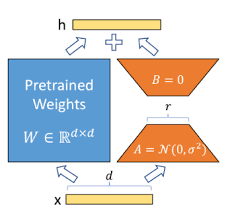

In [7]:
#Applichiamo LoRA al modello che abbiamo caircato precedentemente
peft_config = LoraConfig(
    task_type = None,
    target_modules=["q_proj", "v_proj"], #Matrici della self attention
    inference_mode = False,
    r = 8, #Rango delle matrici
    lora_alpha = 16, #Scaling per stabilizzare la train loss
    lora_dropout = 0.01,
    bias = 'none',
    modules_to_save = ["classifier"]
)


#Apllichiamo LoRA al modello CLIP
lora_model = get_peft_model(model, peft_config)


#Verifichiamo i parametri addestrabili del nuovo modello e notiamo che sono nettamente meno
lora_model.print_trainable_parameters()

trainable params: 302,602 || all params: 86,109,716 || trainable%: 0.3514


In [15]:
#Config dell'addestramento delle due matrici
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=7,
    use_cpu = False,
    eval_strategy='epoch',
    do_eval = True,
    save_strategy='epoch',
    logging_strategy="epoch",
    report_to = "wandb",
    run_name="clip-lora-imagenette",
    remove_unused_columns=False,
    label_names=["labels"],
    logging_steps=10,
    metric_for_best_model="accuracy",
    fp16=True, #per GPU
)

#Funziona per calcolare le metriche di accuracy
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

In [9]:

label_names = dataset["train"].features["label"].names

#Funzione di preprocess sul dataset
def preprocess(examples):
    pixel_batch = processor(images=examples["image"], return_tensors="np")
    examples["pixel_values"] = [pv for pv in pixel_batch.pixel_values]
    
    if isinstance(examples["label"][0], str): #Le etichette numeriche vengono convertite in stringhe
        examples["label"] = [label2id[l] for l in examples["label"]]
    return examples

In [10]:
#Applichiamo il preprocess ai dati
train_dataset = dataset["train"].map(preprocess, batched=True, load_from_cache_file=False)
val_dataset = dataset["validation"].map (preprocess, batched = True, load_from_cache_file=False)

Map:   0%|          | 0/9469 [00:00<?, ? examples/s]

Map:   0%|          | 0/3925 [00:00<?, ? examples/s]

In [11]:
# Imposta formato tensor per PyTorch
train_dataset.set_format(type="torch", columns=["pixel_values", "label"])
val_dataset.set_format(type="torch", columns=["pixel_values", "label"])

In [16]:

#definiamo come deve essere gestito ogni batch e i parametri per il training del modello
def collate_fn(batch):
    # batch è una lista di esempi (dizionari)
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch], dtype=torch.long)
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model = lora_model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.405000,0.283191,0.948535,0.948182
2,0.207500,0.181945,0.961019,0.960697
3,0.142400,0.136033,0.966115,0.965954
4,0.110200,0.115667,0.969936,0.969867
5,0.092400,0.103068,0.972484,0.972417
6,0.082300,0.096913,0.973758,0.973682
7,0.076900,0.095195,0.974777,0.974697


TrainOutput(global_step=1036, training_loss=0.15952451164658005, metrics={'train_runtime': 650.6813, 'train_samples_per_second': 101.867, 'train_steps_per_second': 1.592, 'total_flos': 5.14587369720066e+18, 'train_loss': 0.15952451164658005, 'epoch': 7.0})

In questa sezione ho voluto provare a vedere come funziona la classificazione delle immagini quando le label vengono decise dall'utente, e non corrispondono alle classi dell dataset. \
Quello che ho fatto è stato caricare un'immagine a caso presa da internet (che fosse in una classe di imagenette) per poi provare a visualizzare i valori dei logits.

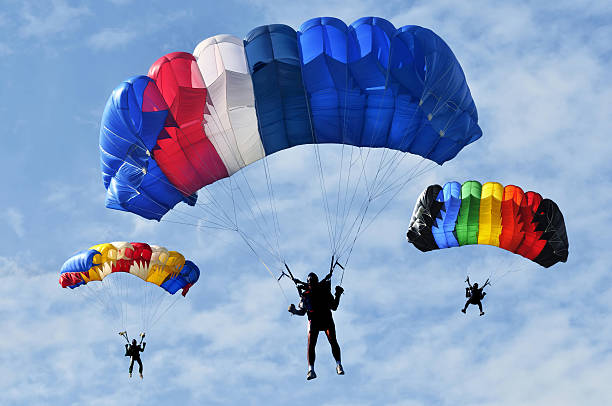

In [5]:

#Proviamo a fare zero-shot validation
class_names = ["cassette player", "a parachute in the sky", "golf ball", "a dog sitting in the grass", "a car on the beach"] #Qualche label del dataset imagenette

#Caricamento di un immagine di un paracadute
url = "https://media.istockphoto.com/id/153503499/photo/three-parachutes.jpg?s=612x612&w=0&k=20&c=Cn6msiRPuJ2jzOzfze3UQElzghQF2ypZKnmFhyLCTZE="
image = Image.open(requests.get(url, stream=True).raw)
display(image)

inputs = processor(text=class_names, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

#Una volta passati dentro il modello estraiamo gli embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

In [6]:
#Ora possiamo prendere gli embeddings e calcolare la similarità coseno, la più alta verrà restituita

image_embeds = F.normalize(image_embeds, dim=-1)
text_embeds = F.normalize(text_embeds, dim=-1)

#Similarità
logits = image_embeds @ text_embeds.T
probs = logits.softmax(dim=-1)

#Predizione
preds = probs.argmax().item()
print(f"Predizione zero-shot: {class_names[preds]} con probabilità {probs[0][preds].item():.2f}")

Predizione zero-shot: a parachute in the sky con probabilità 0.22


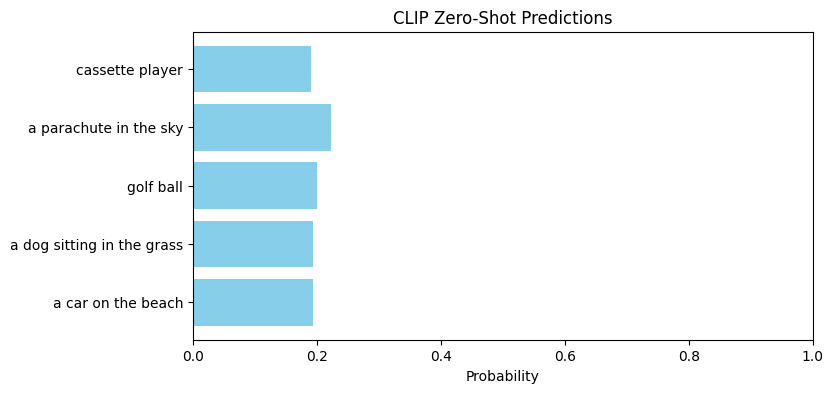

In [7]:


# Converte i tensori PyTorch in array NumPy
probs = probs[0].detach().numpy()

# Crea il grafico a barre
plt.figure(figsize=(8, 4))
plt.barh(class_names, probs, color='skyblue')
plt.xlabel("Probability")
plt.title("CLIP Zero-Shot Predictions")
plt.xlim(0, 1)
plt.gca().invert_yaxis()  # per mettere la classe più probabile in alto
plt.show()